In [10]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import numpy as np

In [11]:
# 准备数据
X, y = make_regression(n_samples=10000, n_features=100, n_informative=10, random_state=0)

In [12]:
# 人为增加噪声
np.random.seed(0)
nosie = np.random.randn(10000) * 10
y += nosie

In [13]:
# 拆分数据集
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [14]:
# 给测试集人为增加噪声
np.random.seed(1)
nosie = np.random.randn(2000) * 10
y_test += nosie

In [15]:
# 数据预处理
mu = X_train.mean(axis=0)
sigma = X_train.std(axis=0) + 1e-10
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

In [16]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        """
            初始化
        """
        self.X = X
        self.y = y

    def __len__(self):
        """
            返回数据集中样本的总个数
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
            用于索引数据
        """
        x_idx = torch.tensor(data=self.X[idx], dtype=torch.float32)
        y_idx = torch.tensor(data=[self.y[idx]], dtype=torch.float32)
        return x_idx, y_idx

In [17]:
# 打包训练集
train_dataset = MyDataset(X=X_train, y=y_train)
# 定义一个数据集的加载器
# shuffle 表示是否打乱数据
# 如果数据集最后一批不够了，有两个策略，一种是丢弃，另一种是直接作为最后一批，通过drop_last=True来控制
# 普通的生成器只能被遍历一次；dataloader也是一个生成器，但是可以被遍历多次
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [18]:
# 打包测试集
test_dataset = MyDataset(X=X_test, y=y_test)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [19]:
# 自定义模型
from torch import nn
# 模型继承自 nn.Module
class Model(nn.Module):
    """自定义深度学习模型"""
    def __init__(self) -> None:
        """初始化"""
        super(Model,self).__init__()
        # 定义一个线性层，可以把100个特征变成了1个特征
        self.fc1 = nn.Linear(in_features=100, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        """
        正向传播过程
            - x: 输入数据，形状为(batch_size, 100)
            - 返回值: 输出数据，形状为(batch_size, 1)
        """
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x
        

In [20]:
"""
PS:模型是一个线性层，结果是怎么算出来的
- 我猜测和我们之前做的一样，第一次线性变换使用的 w和b是随机的。然后后续再不停地优化
"""

'\nPS:模型是一个线性层，结果是怎么算出来的\n- 我猜测和我们之前做的一样，第一次线性变换使用的 w和b是随机的。然后后续再不停地优化\n'

In [21]:
# 创建模型
model = Model()
epochs = 100
learning_rate = 1e-3
loss_fn = nn.MSELoss()
# 优化器
# 优化器做了两个步骤：自动求偏导，清空梯度
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# 记录损失
train_mses = []
test_mses = []


In [22]:
# 过程监控
def get_mse(dataloader, model):
    # 设置模型为评估模式
    model.eval()
    mses = []
    with torch.no_grad():
        for batch_x,batch_y in dataloader:
            y_pred = model(batch_x)
            loss = loss_fn(y_pred, batch_y)
            mse = loss.item()
            mses.append(mse)
    return torch.tensor(mses).mean().item()

In [23]:
"""定义训练过程"""

def train(
        model=model, 
        dataloader = train_dataloader, 
        optimizer = optimizer,  
        loss_fn=loss_fn,
        epochs = epochs
        ):
    
    train_mse = get_mse(dataloader=train_dataloader,model=model)
    test_mse = get_mse(dataloader=test_dataloader,model=model)

    train_mses.append(train_mse)
    test_mses.append(test_mse)

    print(f"在训练之前，模型的在训练集和测试集上的损失为 {train_mse:.4f} {test_mse:.4f}")
    
    
    for epoch in range(epochs):
        # 设置为训练模式
        model.train()
        for batch_idx,(batch_X,batch_y) in enumerate(dataloader):
            # print(f"当前正在训练 {epoch+1} 轮 当前批次为 {batch_idx+1}")
            # 正向传播
            y_pred = model(batch_X)
            # 计算损失
            loss = loss_fn(y_pred,batch_y)
            # 反向传播
            loss.backward()
            # 优化一步
            optimizer.step()
            # 清空梯度
            optimizer.zero_grad()
        # 本轮训练完成之后，计算mse
        train_mse = get_mse(dataloader=train_dataloader,model=model)
        test_mse = get_mse(dataloader=test_dataloader,model=model)
        train_mses.append(train_mse)
        test_mses.append(test_mse)
        print(f"当前正在训练 {epoch+1} 轮 当前训练集损失为 {train_mse:.4f} 当前测试集损失为 {test_mse:.4f}")
        # print(f"当前正在训练 {epoch+1} 轮 当前损失为 {loss.item()}")


In [24]:
train()

在训练之前，模型的在训练集和测试集上的损失为 42919.6172 40433.4531
当前正在训练 1 轮 当前训练集损失为 632.1267 当前测试集损失为 771.1803
当前正在训练 2 轮 当前训练集损失为 239.7838 当前测试集损失为 376.2807
当前正在训练 3 轮 当前训练集损失为 134.4661 当前测试集损失为 269.8095
当前正在训练 4 轮 当前训练集损失为 110.6756 当前测试集损失为 251.9476
当前正在训练 5 轮 当前训练集损失为 98.6247 当前测试集损失为 238.9331
当前正在训练 6 轮 当前训练集损失为 98.7212 当前测试集损失为 239.8329
当前正在训练 7 轮 当前训练集损失为 94.8735 当前测试集损失为 244.8241
当前正在训练 8 轮 当前训练集损失为 87.3571 当前测试集损失为 234.0539
当前正在训练 9 轮 当前训练集损失为 89.7654 当前测试集损失为 244.0027
当前正在训练 10 轮 当前训练集损失为 85.3544 当前测试集损失为 238.7961
当前正在训练 11 轮 当前训练集损失为 84.2275 当前测试集损失为 239.1479
当前正在训练 12 轮 当前训练集损失为 85.0104 当前测试集损失为 242.8803
当前正在训练 13 轮 当前训练集损失为 82.4524 当前测试集损失为 241.8330
当前正在训练 14 轮 当前训练集损失为 80.5790 当前测试集损失为 243.6412
当前正在训练 15 轮 当前训练集损失为 81.4139 当前测试集损失为 247.7670
当前正在训练 16 轮 当前训练集损失为 77.8616 当前测试集损失为 246.3548
当前正在训练 17 轮 当前训练集损失为 77.2874 当前测试集损失为 238.5093
当前正在训练 18 轮 当前训练集损失为 74.1866 当前测试集损失为 242.0536
当前正在训练 19 轮 当前训练集损失为 75.9346 当前测试集损失为 241.5382
当前正在训练 20 轮 当前训练集损失为 73.2551 当前测试集损失为 241.2853
当前正在训练 21 轮 当前训练集损失为

In [25]:
 # 画图
from matplotlib import pyplot as plt

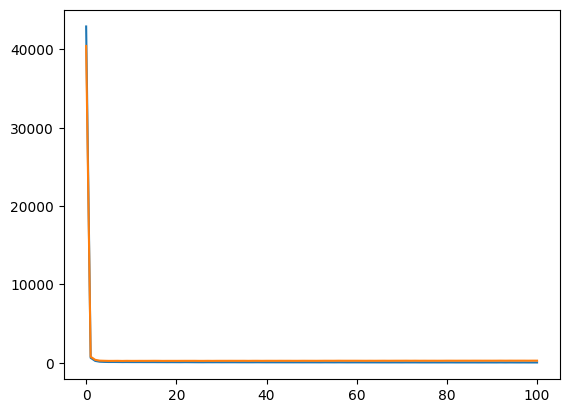

In [26]:
plt.plot(train_mses, label='Train MSE')
plt.plot(test_mses, label='Test MSE')   
# 这两个线重合了，因为是mock的假数据，数据训练效果太好了。

In [72]:
"""模型的保存与加载"""
model

Model(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
# 把模型的网络结构和权重保存在一起的
import joblib
joblib.dump(model, 'model.pkl')

In [ ]:
# 把模型的网络结构和权重保存在一起的
torch.save(model, 'model.torch')

In [ ]:
# 怎么把模型的网络结构和权重分开保存呢？
# 只保存权重
torch.save(model.state_dict(), 'model.pth')

In [ ]:
# 加载模型
model1 = Model()
model1.load_state_dict(torch.load('model.pth'))

In [30]:
# 推理
def predit(X,model=model):
    if not isinstance(X,torch.Tensor):
        X = torch.tensor(X)
    if X.dim() != 2:
        raise ValueError('X must be a 2D tensor')
    
    # 数据预处理
    X = (X - torch.tensor(mu,dtype=torch.float32)) / torch.tensor(sigma,dtype=torch.float32)

    # 评估模式
    model.eval()

    with torch.no_grad():
        y_pred = model(X)
    
    return y_pred


In [34]:
x_to_test,y_to_test = test_dataset[0]
y_pred = predit(X=x_to_test.unsqueeze(dim=0))
print(f'预测结果为：{y_pred}，真实结果为：{y_to_test}')

预测结果为：tensor([[42.6767]])，真实结果为：tensor([46.6686])
